#환경설정

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch

In [10]:
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-0x4obvq1/kobert-tokenizer_4f66aa96f50b41ceb21913eb4e6d3999
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-0x4obvq1/kobert-tokenizer_4f66aa96f50b41ceb21913eb4e6d3999
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done


In [11]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

In [12]:
# Hugging Face를 통한 모델 및 토크나이저 Import
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [13]:
# GPU 사용
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


#Data

In [15]:
import zipfile
import tempfile
import shutil
import os
import json

def load_data(data_dir):
    data = []
    files = os.listdir(data_dir)
    for filename in tqdm(files, desc="Loading data"):
        if filename.endswith('.zip'):
            # 임시 디렉토리 생성
            with tempfile.TemporaryDirectory() as tmpdirname:
                # Zip 파일을 압축 해제
                with zipfile.ZipFile(os.path.join(data_dir, filename), 'r') as zip_ref:
                    zip_ref.extractall(tmpdirname)
                # 임시 디렉토리 내의 파일을 순회
                for root, dirs, files_in_dir in os.walk(tmpdirname):
                    for file_in_dir in files_in_dir:
                        if file_in_dir.endswith('.json'):
                            with open(os.path.join(root, file_in_dir), 'r', encoding='utf-8') as f:
                                json_data = json.load(f)
                                news_title = json_data['sourceDataInfo']['newsTitle']
                                news_content = json_data['sourceDataInfo']['newsContent']
                                sentences = news_content.split('\n')
                                first_sentence = sentences[0]
                                last_sentence = sentences[-1]
                                modified_content = first_sentence + ' ' + last_sentence  # 리소스 이슈로 첫 번째 문장과 마지막 문장만 사용
                                text = ' [CLS] ' + news_title + ' [SEP] ' + modified_content  # title과 content를 이어붙입니다. 모델이 제목과 본문을 구분할 수 있도록 [SEP] 토큰 삽입
                                clickbait_class = json_data['labeledDataInfo']['clickbaitClass']
                                data.append([text, clickbait_class])
    return data

data_dir = '/content/drive/MyDrive/Colab Notebooks/pProject/source/newsdatazip'
data = load_data(data_dir)

Loading data: 100%|██████████| 42/42 [01:04<00:00,  1.53s/it]


In [16]:
print(data[50000])

[' [CLS] SK쉴더스, 오피스넥스와 \'미래형 무인문구점 안심 솔루션 개발\' [SEP] SK쉴더스(대표 박진효)는 오피스용품 유통 기업 오피스넥스와 미래형 무인 문구점 안심 솔루션 개발을 위한 전략적 업무협약(MOU)을 체결했다고 26일 밝혔다. 김윤호 SK쉴더스 전략사업그룹장은 \\"이번 업무협약으로 미래형 무인문구점 운영에 필요한 업계 표준 무인화 솔루션을 마련할 계획이며 양사가 함께 무인문구점 시장을 빠르게 선점할 수 있을 것으로 기대하고 있다\\"며 \\"향후 문구점 특성에 딱 맞는 맞춤형 솔루션을 개발해 미래 가맹 점주들이 더욱 안전하고 효율적으로 매장을 운영할 수 있도록 돕겠다\\"고 말했다.', 1]


In [17]:
from sklearn.model_selection import train_test_split

# 데이터를 학습 데이터와 테스트 데이터, 검증데이터로 분할 => 각 8:1:1 비율
dataset_train, dataset_tmp = train_test_split(data, test_size=0.2, random_state=42)
dataset_test, dataset_val = train_test_split(dataset_tmp, test_size=0.5, random_state=42)

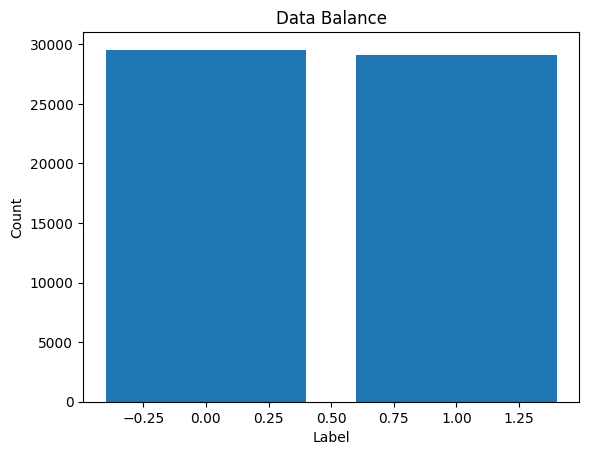

In [18]:
#학습데이터 밸런스 확인
import matplotlib.pyplot as plt

def visualize_data_balance(data):
    label_counts = {}
    for _, label in data:
        if label not in label_counts:
            label_counts[label] = 0
        label_counts[label] += 1

    labels = list(label_counts.keys())
    counts = list(label_counts.values())

    plt.bar(labels, counts)
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('Data Balance')
    plt.show()

visualize_data_balance(dataset_train)

In [19]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, vocab=vocab, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [31]:
# Setting parameters
max_len = 126
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [32]:
tok = tokenizer.tokenize

data_train = BERTDataset(dataset_train, 0, 1, tok, vocab, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, vocab, max_len, True, False)

In [33]:
#torch로 전환
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=3)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=3)

#Model

###사전학습 Model 불러오기

In [34]:
#사전학습된 kobert 모델
print(bertmodel)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(8002, 768, padding_idx=1)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
   

###finetuning

In [35]:
#이진분류
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2, #clickbait 0,1 이진분류
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [36]:
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)
print(model)

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

#Train 1

In [37]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [38]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [39]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

<ipython-input-39-e6a38b13095b>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/917 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 0.6971770524978638 train acc 0.578125
epoch 1 batch id 201 loss 0.7062290906906128 train acc 0.5413557213930348
epoch 1 batch id 401 loss 0.6880717873573303 train acc 0.5642923940149626
epoch 1 batch id 601 loss 0.642581582069397 train acc 0.5702995008319468
epoch 1 batch id 801 loss 0.6432294249534607 train acc 0.5811485642946317
epoch 1 train acc 0.5861494884213228


<ipython-input-39-e6a38b13095b>:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/115 [00:00<?, ?it/s]

epoch 1 test acc 0.6274170480549199


  0%|          | 0/917 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.6338133811950684 train acc 0.609375
epoch 2 batch id 201 loss 0.6764258146286011 train acc 0.6096082089552238
epoch 2 batch id 401 loss 0.6086829900741577 train acc 0.630338216957606
epoch 2 batch id 601 loss 0.5573310852050781 train acc 0.6426008735440932
epoch 2 batch id 801 loss 0.5493078827857971 train acc 0.6521535580524345
epoch 2 train acc 0.6571778043278379


  0%|          | 0/115 [00:00<?, ?it/s]

epoch 2 test acc 0.6336670480549199


  0%|          | 0/917 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.5578674674034119 train acc 0.671875
epoch 3 batch id 201 loss 0.6242931485176086 train acc 0.6850124378109452
epoch 3 batch id 401 loss 0.5402054190635681 train acc 0.7100218204488778
epoch 3 batch id 601 loss 0.4764203727245331 train acc 0.7256135607321131
epoch 3 batch id 801 loss 0.48488494753837585 train acc 0.7341214107365793
epoch 3 train acc 0.7387701263711591


  0%|          | 0/115 [00:00<?, ?it/s]

epoch 3 test acc 0.6387800343249428


  0%|          | 0/917 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.47911110520362854 train acc 0.734375
epoch 4 batch id 201 loss 0.5088596940040588 train acc 0.759717039800995
epoch 4 batch id 401 loss 0.3652825951576233 train acc 0.7824579177057357
epoch 4 batch id 601 loss 0.3779740035533905 train acc 0.7974209650582362
epoch 4 batch id 801 loss 0.36591869592666626 train acc 0.8039364856429463
epoch 4 train acc 0.8075238683259564


  0%|          | 0/115 [00:00<?, ?it/s]

epoch 4 test acc 0.6541261441647598


  0%|          | 0/917 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.37211722135543823 train acc 0.828125
epoch 5 batch id 201 loss 0.43365922570228577 train acc 0.8138215174129353
epoch 5 batch id 401 loss 0.4003802537918091 train acc 0.8343204488778054
epoch 5 batch id 601 loss 0.2632344663143158 train acc 0.842580074875208
epoch 5 batch id 801 loss 0.339119553565979 train acc 0.8438085205992509
epoch 5 train acc 0.8446610991724934


  0%|          | 0/115 [00:00<?, ?it/s]

epoch 5 test acc 0.6576587528604119


In [40]:
#save model
torch.save(model, '/content/drive/MyDrive/Colab Notebooks/pProjectKoBERTClassModel_02_5epoch.pth')

#ROC Curve

threshold의 기준은 Youden's J statistic

In [41]:
data_val = BERTDataset(dataset_val, 0, 1, tok, vocab, max_len, True, False)

#torch로 전환
val_dataloader = torch.utils.data.DataLoader(data_val, batch_size=batch_size, num_workers=3)

<ipython-input-42-53a56d5a32f7>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/115 [00:00<?, ?it/s]

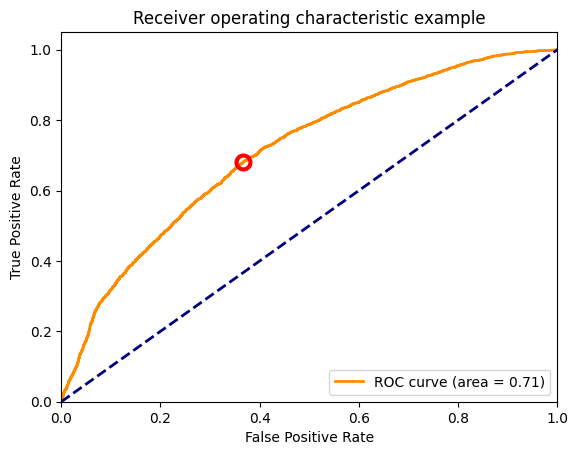

AUC:  0.712225470910723
Optimal Threshold:  -0.16723300516605377


In [42]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

model.eval()
y_test = []
y_pred = []
with torch.no_grad():
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        output = model(token_ids, valid_length, segment_ids)
        y_pred.extend(output[:, 1].cpu().numpy().tolist())
        y_test.extend(label.cpu().numpy().tolist())

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Youden's J statistic을 사용하여 최적의 임계값을 찾습니다.
J = tpr - fpr
opt_idx = np.argmax(J)
opt_threshold = thresholds[opt_idx]
opt_fpr = fpr[opt_idx]
opt_tpr = tpr[opt_idx]

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot(opt_fpr, opt_tpr, 'o', markersize=10, fillstyle='none', c='r', mew=3)  # 최적의 임계값을 표시합니다.
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

print("AUC: ", roc_auc)
print("Optimal Threshold: ", opt_threshold)


#참고
https://github.com/SKTBrain/KoBERT